Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
      tconst       genres
0  tt0000001  Documentary
0  tt0000001        Short
1  tt0000002    Animation
1  tt0000002        Short
2  tt0000003    Animation


<ipython-input-3-556e4a9e69cf>:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  genre_rating = merged_df.groupby('genres').agg(
<ipython-input-3-556e4a9e69cf>:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mean_rating', y='genres', data=genre_rating_sorted, palette='viridis')


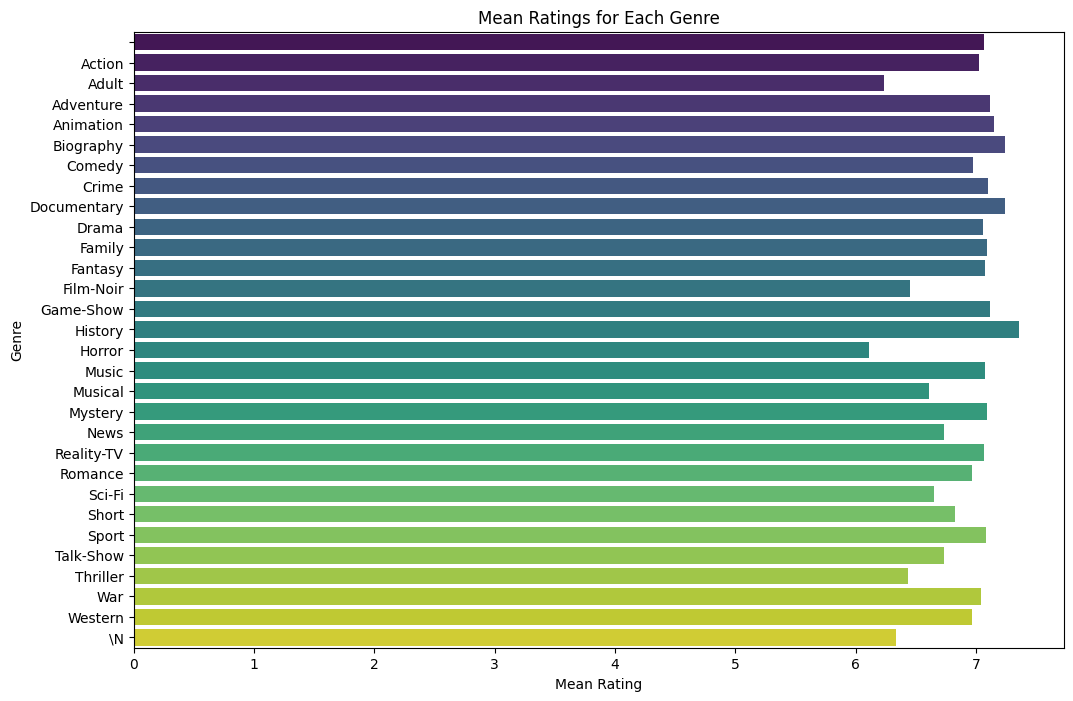

<ipython-input-3-556e4a9e69cf>:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mean_votes', y='genres', data=genre_rating_sorted, palette='coolwarm')


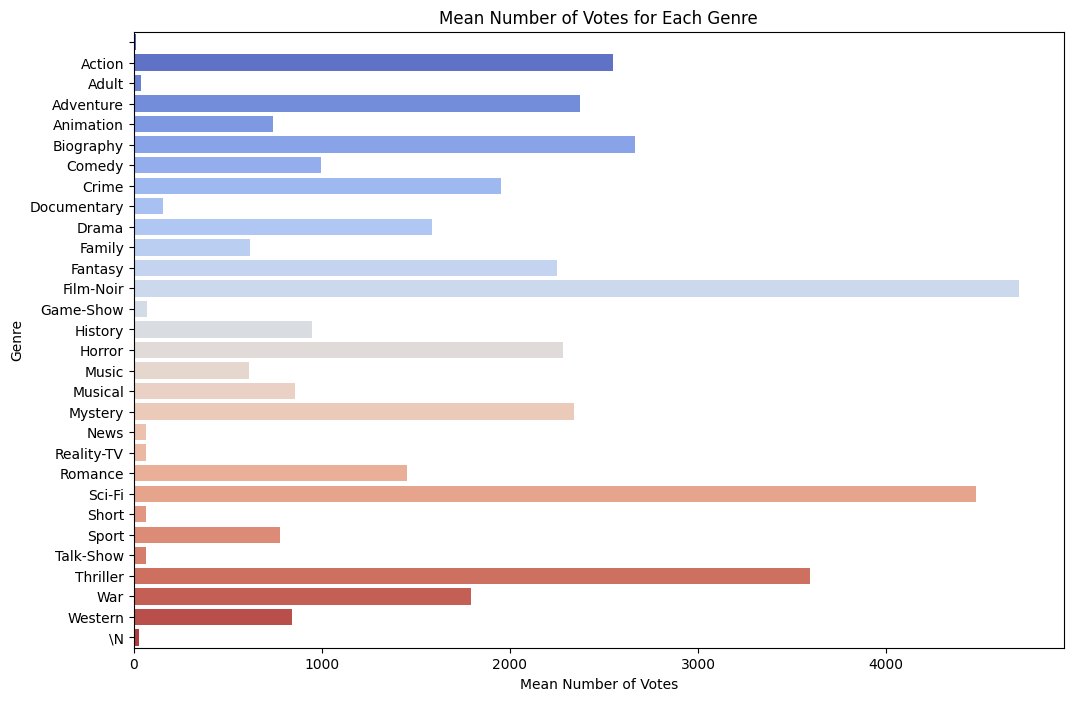

In [3]:
# Step 1: Mount Google Drive to access your files
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

# Step 2: Define the file paths
ratings_path = '/content/drive/MyDrive/title.ratings.tsv.gz'
basics_path = '/content/drive/MyDrive/title.basics.tsv.gz'
zip_path = '/content/drive/MyDrive/rotten_tomatoes_critic_reviews.csv.zip'

# Step 3: Optimize data types and only load necessary columns

# Select only necessary columns from ratings and basics datasets
ratings_columns = ['tconst', 'averageRating', 'numVotes']  # Only keep relevant columns
basics_columns = ['tconst', 'genres']  # Only keep tconst and genres columns

# Load title.ratings.tsv and title.basics.tsv in chunks to avoid memory overload
chunksize = 10000  # Reduced the chunk size to 10,000 to further reduce memory load

# Read title.ratings.tsv in chunks and process
ratings_df_chunks = pd.read_csv(ratings_path, sep='\t', usecols=ratings_columns, chunksize=chunksize)

# Initialize an empty DataFrame to store the processed data
ratings_df = pd.concat(ratings_df_chunks)

# Convert data types to reduce memory usage
ratings_df['averageRating'] = ratings_df['averageRating'].astype('float32')
ratings_df['numVotes'] = ratings_df['numVotes'].astype('int32')

# Read title.basics.tsv in chunks and process
basics_df_chunks = pd.read_csv(basics_path, sep='\t', usecols=basics_columns, chunksize=chunksize)

# Initialize an empty DataFrame to store the processed data
basics_df = pd.concat(basics_df_chunks)

# Fill missing genres and split by commas
basics_df['genres'] = basics_df['genres'].fillna('')

# Explode the genres column to handle each genre in a separate row
exploded_genres_df = basics_df.dropna(subset=['genres']).copy()
exploded_genres_df['genres'] = exploded_genres_df['genres'].str.split(',')
exploded_genres_df = exploded_genres_df.explode('genres')

# Convert 'genres' to category type for more memory efficiency
exploded_genres_df['genres'] = exploded_genres_df['genres'].astype('category')

# Check the first few rows to ensure correct data processing
print(exploded_genres_df.head())

# Step 4: Merge the exploded genres DataFrame with the ratings DataFrame on 'tconst'
merged_df = pd.merge(exploded_genres_df, ratings_df, on='tconst', how='left')

# Step 5: Calculate the mean rating and vote count for each genre
genre_rating = merged_df.groupby('genres').agg(
    mean_rating=('averageRating', 'mean'),
    mean_votes=('numVotes', 'mean')
).reset_index()

# Sort by mean rating
genre_rating_sorted = genre_rating.sort_values(by='mean_rating', ascending=False)

# Step 6: Plot the mean ratings for each genre
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(x='mean_rating', y='genres', data=genre_rating_sorted, palette='viridis')
plt.title('Mean Ratings for Each Genre')
plt.xlabel('Mean Rating')
plt.ylabel('Genre')
plt.show()

# Step 7: Plot the mean number of votes for each genre
plt.figure(figsize=(12, 8))
sns.barplot(x='mean_votes', y='genres', data=genre_rating_sorted, palette='coolwarm')
plt.title('Mean Number of Votes for Each Genre')
plt.xlabel('Mean Number of Votes')
plt.ylabel('Genre')
plt.show()
